In [1]:
# suppress any warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import shap
from PIL import Image

In [4]:
!pip install shap

In [5]:
data_dir = "/content/drive/My Drive/C-NMC/training_data"
test_image = "/content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_4_1_hem.bmp"

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import shap
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [7]:
class SHAPExplainer:
  def __init__(self, model_path, class_names=['Healthy', 'Leukemia']):
    """
    Initialize SHAP explainer for leukemia detection
    """
    self.model = load_model(model_path)
    self.class_names = class_names

    # create prediction function for SHAP
    self.predict_fn = self._create_prediction_function()

    print(f"Model loaded from: {model_path}")
    print(f"Model input shape: {self.model.input_shape}")
    print(f"Classes: {self.class_names}")

  def _create_prediction_function(self):
    """
    Create a prediction function compatible with SHAP
    """
    def predict(images):
      # handle different input shapes
      if len(images.shape) == 3:
        images = np.expand_dims(images, axis=0)

      # ensure proper preprocessing
      processed_images = []
      for img in images:
        if img.shape[:2] != (226, 226):
          img_resized = cv2.resize(img, (226, 226))
        else:
          img_resized = img

        # preprocess for model
        img_processed = preprocess_input(img_resized.astype(np.float32))
        processed_images.append(img_processed)

      processed_images = np.array(processed_images)

      # get predictions
      predictions = self.model.predict(processed_images, verbose=0)

      # apply softmax (for binary classification)
      if predictions.shape[1] == 2:
        predictions = tf.nn.softmax(predictions).numpy()

      return predictions

    return predict

  def create_background_dataset(self, data_dir, num_samples=50):
    """
    Create background dataset for SHAP from training data
    """
    # get all image files with more extensions
    image_files = []
    for root, dirs, files in os.walk(data_dir):
      for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif')):
          image_files.append(os.path.join(root, file))

    print(f"Found {len(image_files)} total images")

    if len(image_files) == 0:
      raise ValueError(f"No image files found in {data_dir}")

    # randomly sample images
    sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

    background_data = []
    for img_path in sampled_files:
      try:
        img = image.load_img(img_path, target_size=(226, 226))
        img_array = np.array(img)
        background_data.append(img_array)
      except Exception as e:
        print(f"Error loading {img_path}: {e}")
        continue

    if len(background_data) == 0:
      raise ValueError("No background images could be loaded successfully")

    background_data = np.array(background_data)
    print(f"Created background dataset with {len(background_data)} images")

    return background_data

  def explain_image_partition(self, img_path, background_data, max_evals=500, save_path=None):
    """
    Generate SHAP explanation using Image masker (better for images than Partition)
    """
    # load and preprocess image
    img = image.load_img(img_path, target_size=(226, 226))
    img_array = np.array(img)

    print(f"Explaining image: {img_path}")
    print(f"Image shape: {img_array.shape}")

    # get original prediction
    original_pred = self.predict_fn(img_array)
    predicted_class = np.argmax(original_pred[0])
    confidence = original_pred[0][predicted_class]

    print(f"Original prediction: {self.class_names[predicted_class]} (confidence: {confidence:.3f})")

    # initialize SHAP explainer
    print("Initializing SHAP Image explainer...")
    # use simpler masker
    try:
      # try inpainting masker
      masker = shap.maskers.Image("inpaint_telea", background_data[0].shape)
      explainer = shap.Explainer(self.predict_fn, masker)
    except Exception as e:
      print(f"Inpainting masker failed: {e}")
      print("Trying blur masker...")
      # fallback to blur masker
      masker = shap.maskers.Image("blur(1,1)", background_data[0].shape)
      explainer = shap.Explainer(self.predict_fn, masker)

    # generate SHAP values
    print(f"Computing SHAP values (max_evals={max_evals})...")
    shap_values = explainer(np.expand_dims(img_array, axis=0), max_evals=max_evals)

    # visualizations
    self._create_shap_visualizations(
      img_array, shap_values, predicted_class, confidence, save_path
    )

    return shap_values

  def explain_image_deep(self, img_path, background_data, save_path=None):
    """
    Generate SHAP explanation using Deep explainer
    """
    # load and preprocess image
    img = image.load_img(img_path, target_size=(226, 226))
    img_array = np.array(img)

    print(f"Explaining image: {img_path}")

    # get original prediction
    original_pred = self.predict_fn(img_array)
    predicted_class = np.argmax(original_pred[0])
    confidence = original_pred[0][predicted_class]

    print(f"Original prediction: {self.class_names[predicted_class]} (confidence: {confidence:.3f})")

    # preprocess background data
    background_processed = []
    for bg_img in background_data[:10]: # use fewer background samples for Deep explainer
      bg_processed = preprocess_input(bg_img.astype(np.float32))
      background_processed.append(bg_processed)
    background_processed = np.array(background_processed)

    # initialize SHAP Deep explainer
    print("Initializing SHAP Deep explainer...")
    explainer = shap.DeepExplainer(self.model, background_processed)

    # preprocess test image
    img_processed = preprocess_input(img_array.astype(np.float32))
    img_processed = np.expand_dims(img_processed, axis=0)

    # generate SHAP values
    print("Computing SHAP values...")
    shap_values = explainer.shap_values(img_processed)

    # visualizations
    self._create_deep_shap_visualizations(
      img_array, shap_values, predicted_class, confidence, save_path
    )

    return shap_values

  def _create_shap_visualizations(self, img_array, shap_values, predicted_class, confidence, save_path):
    """
    Create visualizations for SHAP Partition explainer results
    """
    # extract SHAP values for predicted class
    if hasattr(shap_values, 'values'):
      values = shap_values.values[0, :, :, :, predicted_class]
    else:
      values = shap_values[0, :, :, :, predicted_class]

    # figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # original image
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title(f'Original Image\\n{self.class_names[predicted_class]} (conf: {confidence:.3f})')
    axes[0, 0].axis('off')

    # SHAP heatmap (average across channels)
    shap_heatmap = np.mean(np.abs(values), axis=2)
    im1 = axes[0, 1].imshow(shap_heatmap, cmap='hot')
    axes[0, 1].set_title('SHAP Importance Heatmap')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

    # normalize SHAP values for overlay
    shap_normalized = (shap_heatmap - shap_heatmap.min()) / (shap_heatmap.max() - shap_heatmap.min())
    shap_resized = cv2.resize(shap_normalized, (img_array.shape[1], img_array.shape[0]))

    # create colored overlay
    shap_colored = plt.cm.hot(shap_resized)[:, :, :3] # remove alpha channel
    overlay = 0.6 * img_array.astype(float) / 255 + 0.4 * shap_colored * 255
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    axes[1, 0].imshow(overlay)
    axes[1, 0].set_title('SHAP Overlay')
    axes[1, 0].axis('off')

    # SHAP values distribution
    axes[1, 1].hist(values.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('SHAP Values Distribution')
    axes[1, 1].set_xlabel('SHAP Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
      print(f"Saved SHAP explanation to: {save_path}")

    plt.show()

    # summary statistics
    self._print_shap_statistics(values, predicted_class)

  def _create_deep_shap_visualizations(self, img_array, shap_values, predicted_class, confidence, save_path):
    """
    Create visualizations for SHAP Deep explainer results
    """
    # SHAP values for predicted class
    if isinstance(shap_values, list):
      values = shap_values[predicted_class][0] # first image, predicted class
    else:
      values = shap_values[0, :, :, :, predicted_class]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # original image
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title(f'Original Image\\n{self.class_names[predicted_class]} (conf: {confidence:.3f})')
    axes[0, 0].axis('off')

    # SHAP heatmap
    shap_heatmap = np.mean(np.abs(values), axis=2)
    im1 = axes[0, 1].imshow(shap_heatmap, cmap='RdBu_r')
    axes[0, 1].set_title('SHAP Deep Heatmap')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

    # positive and negative contributions
    positive_values = np.maximum(values, 0)
    negative_values = np.minimum(values, 0)

    pos_heatmap = np.mean(positive_values, axis=2)
    neg_heatmap = np.mean(np.abs(negative_values), axis=2)

    im2 = axes[1, 0].imshow(pos_heatmap, cmap='Reds')
    axes[1, 0].set_title('Positive Contributions')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0], fraction=0.046)

    im3 = axes[1, 1].imshow(neg_heatmap, cmap='Blues')
    axes[1, 1].set_title('Negative Contributions')
    axes[1, 1].axis('off')
    plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)

    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
      print(f"Saved Deep SHAP explanation to: {save_path}")

    plt.show()

    self._print_shap_statistics(values, predicted_class)

  def _print_shap_statistics(self, values, predicted_class):
    """
    Print summary statistics for SHAP values
    """
    print(f"\\nSHAP Statistics for {self.class_names[predicted_class]}:")
    print(f"SHAP values shape: {values.shape}")
    print(f"Mean SHAP value: {np.mean(values):.6f}")
    print(f"Std SHAP value: {np.std(values):.6f}")
    print(f"Max positive contribution: {np.max(values):.6f}")
    print(f"Max negative contribution: {np.min(values):.6f}")
    print(f"Total positive contribution: {np.sum(np.maximum(values, 0)):.6f}")
    print(f"Total negative contribution: {np.sum(np.minimum(values, 0)):.6f}")

    # find most important regions
    if len(values.shape) == 3: # (height, width, channels)
      # average across channels first
      values_2d = np.mean(np.abs(values), axis=2)
      flattened = values_2d.reshape(-1)
      top_indices = np.argsort(flattened)[-10:] # top 10 important pixels

      print(f"\\nTop 10 most important pixel contributions:")
      for i, idx in enumerate(top_indices[::-1]):
        y, x = np.unravel_index(idx, values_2d.shape)
        print(f"  {i+1}. Pixel ({x:3d}, {y:3d}): {flattened[idx]:+.6f}")
    else:
      # handle other shapes
      flattened = values.reshape(-1)
      if len(flattened) > 0:
        top_indices = np.argsort(np.abs(flattened))[-min(10, len(flattened)):]
        print(f"\\nTop {len(top_indices)} most important contributions:")
        for i, idx in enumerate(top_indices[::-1]):
          print(f"  {i+1}. Index {idx:6d}: {flattened[idx]:+.6f}")
      else:
        print("\\nNo SHAP values to analyze")

  def compare_shap_methods(self, img_path, background_data, save_path=None):
    """
    Compare SHAP Partition and Deep explainer results
    """
    print("Comparing SHAP methods...")

    # get explanations from both methods
    print("\\n1. Running Partition explainer...")
    shap_partition = self.explain_image_partition(img_path, background_data, max_evals=200)

    print("\\n2. Running Deep explainer...")
    shap_deep = self.explain_image_deep(img_path, background_data[:10]) # fewer background samples

    # load original image
    img = image.load_img(img_path, target_size=(226, 226))
    img_array = np.array(img)

    # get prediction
    pred = self.predict_fn(img_array)
    predicted_class = np.argmax(pred[0])

    # extract values for comparison
    if hasattr(shap_partition, 'values'):
      partition_values = shap_partition.values[0, :, :, :, predicted_class]
    else:
      partition_values = shap_partition[0, :, :, :, predicted_class]

    if isinstance(shap_deep, list):
      deep_values = shap_deep[predicted_class][0]
    else:
      deep_values = shap_deep[0, :, :, :, predicted_class]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # original image
    axes[0, 0].imshow(img_array)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    axes[1, 0].axis('off') # empty space

    # partition explainer results
    partition_heatmap = np.mean(np.abs(partition_values), axis=2)
    im1 = axes[0, 1].imshow(partition_heatmap, cmap='hot')
    axes[0, 1].set_title('SHAP Partition')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046)

    # deep explainer results
    deep_heatmap = np.mean(np.abs(deep_values), axis=2)
    im2 = axes[0, 2].imshow(deep_heatmap, cmap='hot')
    axes[0, 2].set_title('SHAP Deep')
    axes[0, 2].axis('off')
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046)

    # normalize both heatmaps for comparison
    partition_norm = (partition_heatmap - partition_heatmap.min()) / (partition_heatmap.max() - partition_heatmap.min())
    deep_norm = (deep_heatmap - deep_heatmap.min()) / (deep_heatmap.max() - deep_heatmap.min())

    difference = partition_norm - deep_norm
    im3 = axes[1, 1].imshow(difference, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1, 1].set_title('Difference (Partition - Deep)')
    axes[1, 1].axis('off')
    plt.colorbar(im3, ax=axes[1, 1], fraction=0.046)

    # correlation plot
    axes[1, 2].scatter(partition_heatmap.flatten(), deep_heatmap.flatten(), alpha=0.5)
    axes[1, 2].set_xlabel('Partition SHAP')
    axes[1, 2].set_ylabel('Deep SHAP')
    axes[1, 2].set_title('Method Correlation')

    # calculate correlation
    correlation = np.corrcoef(partition_heatmap.flatten(), deep_heatmap.flatten())[0, 1]
    axes[1, 2].text(0.05, 0.95, f'r = {correlation:.3f}', transform=axes[1, 2].transAxes,
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
      print(f"Saved comparison to: {save_path}")

    plt.show()

    print(f"\\nMethod Comparison Results:")
    print(f"Correlation coefficient: {correlation:.3f}")
    print(f"Mean absolute difference: {np.mean(np.abs(difference)):.3f}")

    return {
      'partition_values': partition_values,
      'deep_values': deep_values,
      'correlation': correlation,
      'difference': difference
    }

  def batch_shap_analysis(self, image_paths, background_data, method='partition', save_dir=None):
    """
    Run SHAP analysis on multiple images
    """
    results = {}

    for i, img_path in enumerate(image_paths):
      print(f"Analyzing image {i+1}/{len(image_paths)}: {img_path}")

      try:
        save_path = f"{save_dir}/shap_{method}_image_{i+1}.png" if save_dir else None

        if method == 'partition':
          shap_values = self.explain_image_partition(img_path, background_data, save_path=save_path)
        elif method == 'deep':
          shap_values = self.explain_image_deep(img_path, background_data, save_path=save_path)
        else:
          raise ValueError("Method must be 'partition' or 'deep'")

        results[f'image_{i+1}'] = {
          'path': img_path,
          'shap_values': shap_values,
          'method': method
        }
      except Exception as e:
        print(f"Error analyzing {img_path}: {e}")
        results[f'image_{i+1}'] = None

    return results

In [8]:
def model_comparison_shap(model_paths, test_image, background_data, method='partition'):
  """
  Compare SHAP explanations across different models
  """
  explanations = {}
  predictions = {}

  # load test image
  img = image.load_img(test_image, target_size=(226, 226))
  img_array = np.array(img)

  # generate explanations for each model
  for model_name, model_path in model_paths.items():
    print(f"Analyzing with {model_name}")

    try:
      explainer = SHAPExplainer(model_path)

      # get prediction
      pred = explainer.predict_fn(img_array)
      predictions[model_name] = pred[0]
      predicted_class = np.argmax(pred[0])

      # get SHAP explanation
      if method == 'partition':
        shap_values = explainer.explain_image_partition(test_image, background_data, max_evals=200)
      else:
        shap_values = explainer.explain_image_deep(test_image, background_data)

      explanations[model_name] = {
        'shap_values': shap_values,
        'predicted_class': predicted_class,
        'confidence': pred[0][predicted_class]
      }
    except Exception as e:
      print(f"Error with {model_name}: {e}")
      explanations[model_name] = None

  # comparison visualization
  create_shap_model_comparison(img_array, explanations, predictions)

  return explanations, predictions

In [9]:
def create_shap_model_comparison(img_array, explanations, predictions):
  """
  Create comparison visualization of SHAP explanations across models
  """
  valid_explanations = {k: v for k, v in explanations.items() if v is not None}
  num_models = len(valid_explanations)

  if num_models == 0:
    print("No valid explanations to compare")
    return

  class_names = ['Healthy', 'Leukemia']

  fig, axes = plt.subplots(2, num_models + 1, figsize=(4 * (num_models + 1), 8))

  # original image
  axes[0, 0].imshow(img_array)
  axes[0, 0].set_title('Original Image')
  axes[0, 0].axis('off')

  # prediction comparison
  model_names = list(valid_explanations.keys())
  x_pos = np.arange(len(class_names))
  width = 0.8 / num_models

  for i, model_name in enumerate(model_names):
    offset = (i - num_models/2 + 0.5) * width
    axes[1, 0].bar(x_pos + offset, predictions[model_name], width, label=model_name, alpha=0.8)

  axes[1, 0].set_xlabel('Classes')
  axes[1, 0].set_ylabel('Probability')
  axes[1, 0].set_title('Prediction Comparison')
  axes[1, 0].set_xticks(x_pos)
  axes[1, 0].set_xticklabels(class_names)
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # model explanations
  for i, (model_name, explanation) in enumerate(valid_explanations.items()):
    col = i + 1
    predicted_class = explanation['predicted_class']
    confidence = explanation['confidence']

    # extract SHAP values
    shap_values = explanation['shap_values']
    if hasattr(shap_values, 'values'):
      values = shap_values.values[0, :, :, :, predicted_class]
    elif isinstance(shap_values, list):
      values = shap_values[predicted_class][0]
    else:
      values = shap_values[0, :, :, :, predicted_class]

    # create heatmap
    heatmap = np.mean(np.abs(values), axis=2)

    # plot explanation
    im1 = axes[0, col].imshow(heatmap, cmap='hot')
    axes[0, col].set_title(f'{model_name}\\n{class_names[predicted_class]} ({confidence:.3f})')
    axes[0, col].axis('off')

    # plot overlay
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    overlay = 0.6 * img_array.astype(float) / 255 + 0.4 * plt.cm.hot(heatmap_norm)[:, :, :3] * 255
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)

    axes[1, col].imshow(overlay)
    axes[1, col].set_title(f'{model_name} Overlay')
    axes[1, col].axis('off')

  plt.tight_layout()
  plt.savefig('shap_model_comparison.png', dpi=300, bbox_inches='tight')
  print("Saved comparison to: shap_model_comparison.png")
  plt.show()

In [10]:
def example_single_shap_analysis():
  """
  Single model SHAP analysis
  """
  model_path = "/content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras"
  test_image = "/content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_4_1_hem.bmp"
  data_dir = "/content/drive/My Drive/C-NMC/training_data"

  # initialize explainer
  explainer = SHAPExplainer(model_path)

  # create background dataset
  background_data = explainer.create_background_dataset(data_dir, num_samples=50)

  # run SHAP analysis
  shap_values = explainer.explain_image_partition(test_image, background_data, save_path='shap_explanation.png')

  # compare methods
  comparison = explainer.compare_shap_methods(test_image, background_data, save_path='shap_comparison.png')

  return shap_values, comparison

In [11]:
def example_multi_model_shap():
  """
  Multi-model SHAP comparison
  """
  model_paths = {
      'CNN_Unbalanced': "/content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras",
      'CNN_DCGAN': "/content/drive/My Drive/code/CNNs/dcgan-cnn/cnn_dcgan-balanced_model.keras",
      'ViT_Unbalanced': "/content/drive/My Drive/code/ViTs/unbalanced-vit/vit_unbalanced_model.keras"
  }

  test_image = "/content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_4_1_hem.bmp"
  data_dir = "/content/drive/My Drive/C-NMC/training_data"

  # background data
  explainer = SHAPExplainer(list(model_paths.values())[0]) # first model to create background
  background_data = explainer.create_background_dataset(data_dir, num_samples=30)

  # compare models
  explanations, predictions = model_comparison_shap(model_paths, test_image, background_data)

  return explanations, predictions

In [12]:
def quick_shap_analysis(model_path, image_path, data_dir):
  """
  Quick SHAP analysis with default settings
  """
  explainer = SHAPExplainer(model_path)
  background_data = explainer.create_background_dataset(data_dir, num_samples=30)
  shap_values = explainer.explain_image_partition(image_path, background_data, max_evals=300)
  return shap_values

In [13]:
healthy_cell = "/content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_1_1_hem.bmp"
cancer_cell = "/content/drive/My Drive/C-NMC/training_data/fold_0/all/UID_1_3_1_all.bmp"

cnn_unbalanced = "/content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras"
cnn_dcgan = "/content/drive/My Drive/code/CNNs/dcgan-cnn/cnn_dcgan-balanced_model.keras"
vit_unbalanced = "/content/drive/My Drive/code/ViTs/unbalanced-vit/vit-unbalanced_model.keras"

In [14]:
data_dir = "/content/drive/My Drive/C-NMC/training_data"

Model loaded from: /content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras
Model input shape: (None, 226, 226, 3)
Classes: ['Healthy', 'Leukemia']
Found 10661 total images
Created background dataset with 30 images
Analyzing with CNN_Unbalanced
Model loaded from: /content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras
Model input shape: (None, 226, 226, 3)
Classes: ['Healthy', 'Leukemia']
Explaining image: /content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_4_1_hem.bmp
Image shape: (226, 226, 3)
Original prediction: Healthy (confidence: 1.000)
Initializing SHAP Image explainer...
Computing SHAP values (max_evals=200)...


  0%|          | 0/198 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.99s/it]               


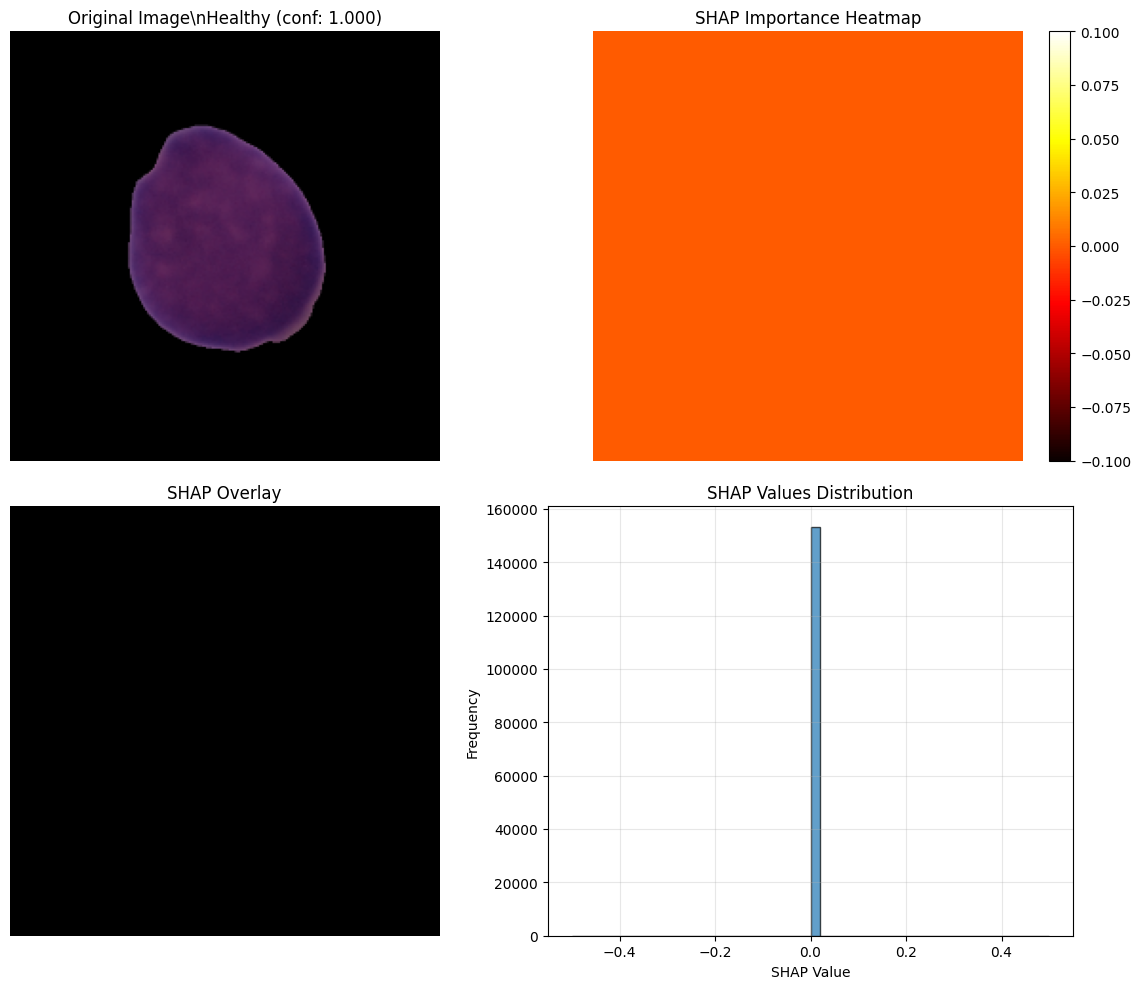

\nSHAP Statistics for Healthy:
SHAP values shape: (226, 226, 3)
Mean SHAP value: 0.000000
Std SHAP value: 0.000000
Max positive contribution: 0.000000
Max negative contribution: 0.000000
Total positive contribution: 0.000000
Total negative contribution: 0.000000
\nTop 10 most important pixel contributions:
  1. Pixel (  0,   0): +0.000000
  2. Pixel (225, 225): +0.000000
  3. Pixel (224, 225): +0.000000
  4. Pixel (223, 225): +0.000000
  5. Pixel ( 16,   0): +0.000000
  6. Pixel ( 17,   0): +0.000000
  7. Pixel ( 18,   0): +0.000000
  8. Pixel ( 19,   0): +0.000000
  9. Pixel ( 20,   0): +0.000000
  10. Pixel ( 21,   0): +0.000000
Analyzing with CNN_DCGAN
Model loaded from: /content/drive/My Drive/code/CNNs/dcgan-cnn/cnn_dcgan-balanced_model.keras
Model input shape: (None, 226, 226, 3)
Classes: ['Healthy', 'Leukemia']
Explaining image: /content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H6_4_1_hem.bmp
Image shape: (226, 226, 3)
Original prediction: Healthy (confidence: 1.000)
In

  0%|          | 0/198 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.91s/it]               


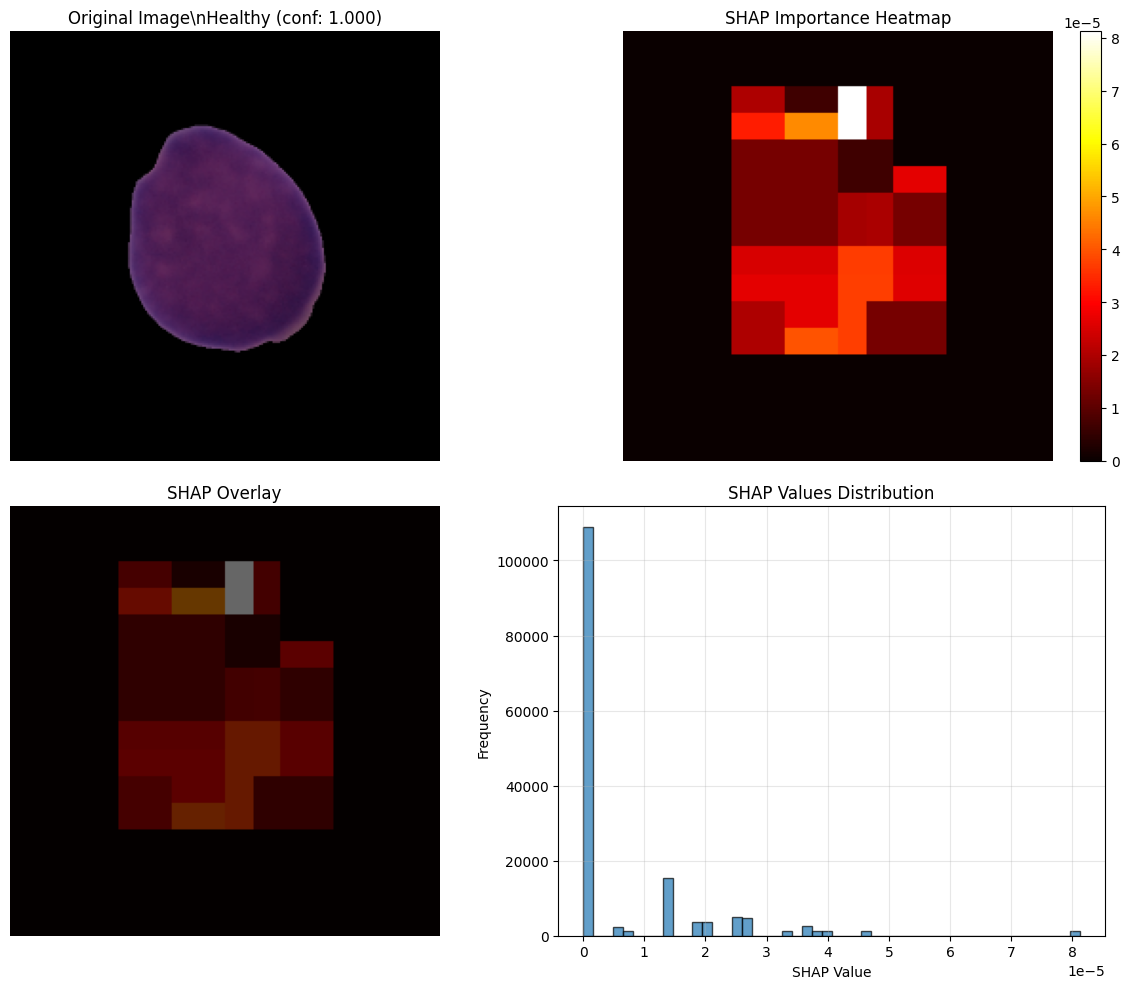

\nSHAP Statistics for Healthy:
SHAP values shape: (226, 226, 3)
Mean SHAP value: 0.000007
Std SHAP value: 0.000013
Max positive contribution: 0.000081
Max negative contribution: 0.000000
Total positive contribution: 1.000000
Total negative contribution: 0.000000
\nTop 10 most important pixel contributions:
  1. Pixel (125,  46): +0.000081
  2. Pixel (126,  46): +0.000081
  3. Pixel (127,  46): +0.000081
  4. Pixel (113,  47): +0.000081
  5. Pixel (114,  47): +0.000081
  6. Pixel (125,  31): +0.000081
  7. Pixel (126,  31): +0.000081
  8. Pixel (127,  31): +0.000081
  9. Pixel (115,  47): +0.000081
  10. Pixel (116,  47): +0.000081
Analyzing with ViT_Unbalanced
Error with ViT_Unbalanced: File not found: filepath=/content/drive/My Drive/code/ViTs/unbalanced-vit/vit_unbalanced_model.keras. Please ensure the file is an accessible `.keras` zip file.
Saved comparison to: shap_model_comparison.png


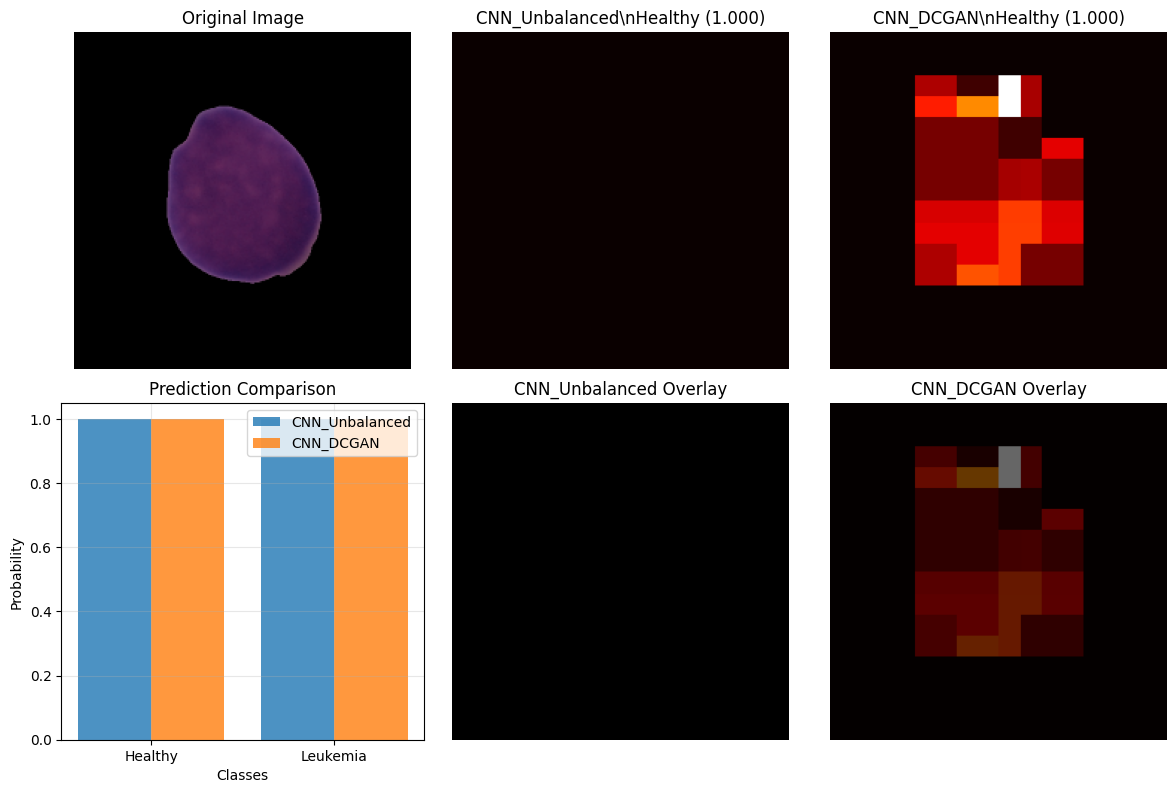

In [15]:
# model comparison:
explanations, predictions = example_multi_model_shap()

Model loaded from: /content/drive/My Drive/code/CNNs/dcgan-cnn/cnn_dcgan-balanced_model.keras
Model input shape: (None, 226, 226, 3)
Classes: ['Healthy', 'Leukemia']
Found 10661 total images
Created background dataset with 30 images
Explaining image: /content/drive/My Drive/C-NMC/training_data/fold_0/all/UID_1_3_1_all.bmp
Image shape: (226, 226, 3)
Original prediction: Healthy (confidence: 1.000)
Initializing SHAP Image explainer...
Computing SHAP values (max_evals=300)...


  0%|          | 0/298 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:33, 33.91s/it]               


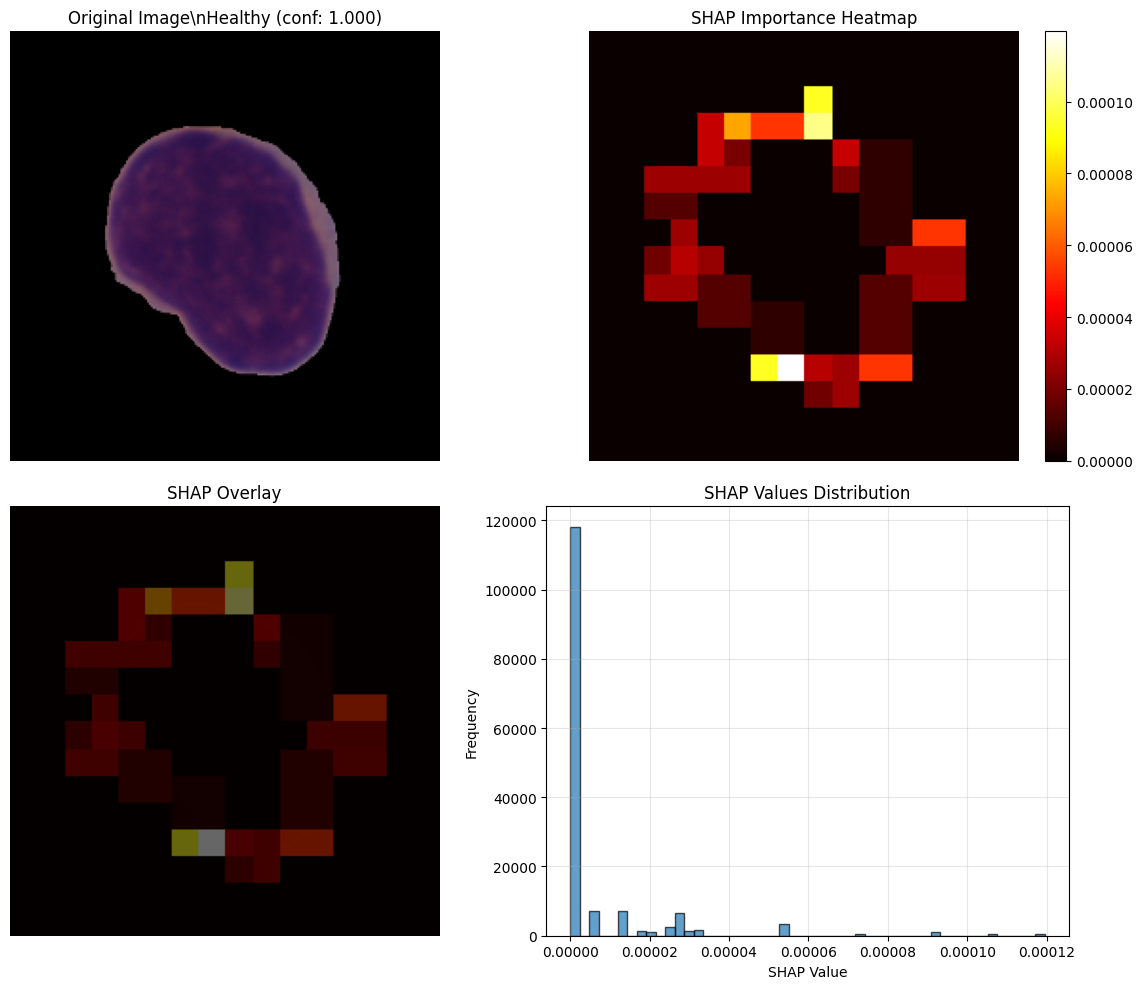

\nSHAP Statistics for Healthy:
SHAP values shape: (226, 226, 3)
Mean SHAP value: 0.000007
Std SHAP value: 0.000017
Max positive contribution: 0.000120
Max negative contribution: 0.000000
Total positive contribution: 1.000000
Total negative contribution: 0.000000
\nTop 10 most important pixel contributions:
  1. Pixel (102, 178): +0.000120
  2. Pixel (101, 178): +0.000120
  3. Pixel (100, 178): +0.000120
  4. Pixel ( 99, 178): +0.000120
  5. Pixel (112, 178): +0.000120
  6. Pixel (111, 178): +0.000120
  7. Pixel (110, 178): +0.000120
  8. Pixel (109, 178): +0.000120
  9. Pixel (108, 177): +0.000120
  10. Pixel (107, 177): +0.000120


In [16]:
# try with leukemia cell to see different patterns
shap_values_cancer = quick_shap_analysis(cnn_dcgan, cancer_cell, data_dir)